In [46]:
;; This is a showcase of Escher's square limit generation in Scheme (https://www.nga.gov/collection/art-object-page.135604.html)
;; Checkout day1.ipynb for the process

(import "sys")
(import "builtins")
(import "math")

(define python builtins)

;; SVG

(import "IPython.display")

(define SVG IPython.display.SVG)
(define HTML IPython.display.HTML)

(define (render-svg-text w h shape)
    (string-append
         (format 
          "<svg version='1.1' viewBox='~a ~a ~a ~a' width='~a' height='~a' fill='none' stroke='black' xmlns='http://www.w3.org/2000/svg'>"
          (/ w -2.0)
          (/ h -2.0)
          w
          h
          w
          h)
         (shape)
         "</svg>"))

(define (render-svg w h shape)
  (SVG (render-svg-text w h shape)))

(define (render shape)
  (render-svg 200 200 shape))


(define (render-debug shape)
  (render (apply combine-generic-args 
                 (list   
                  shape 
                  (rectangle 200 200)
                  (line -100 0 100 0)
                  (line 0 -100 0 100)))))

;; Shapes

(define (circle r)
  (lambda ()
      (format "<circle r='~a' />" r)))

(define (rectangle w h)
  (lambda ()
      (format "<rect x='~a' y='~a' width='~a' height='~a' />" 
              (/ w -2.0) (/ h -2.0) w h)))


(define (line x1 y1 x2 y2)
  (lambda () 
    (format "<line x1='~a' y1='~a' x2='~a' y2='~a' />" x1 y1 x2 y2)))



;; Transformation

;; transform creates a function that takes a shape 
;; and returns a new shape after applying the given transform
(define (transform t)
  (lambda (shape)
    (lambda ()
      (format "<g transform='~a'>~a</g>" t (shape)))))



(define (rotate angle)
  (transform (format "rotate(~a)" angle)))

(define (translate x y)
  (transform (format "translate(~a, ~a)" x y)))

(define (scale x y)
  (transform (format "scale(~a, ~a)" x y)))

;; Split


(define (beside s1 s2) 
      (combine (pipeline 
                    s1
                    (translate -100 0)
                    (scale 0.5 1))
               (pipeline
                    s2
                    (translate 100 0)
                    (scale 0.5 1))))

(define (below s1 s2) 
      (combine (pipeline 
                    s1
                    (translate 0 -100)
                    (scale 1 0.5))
               (pipeline
                    s2
                    (translate 0 100)
                    (scale 1 0.5))))

(define (quartlet p q r s) 
      (below (beside p q) (beside r s)))

(define (right-split shape n) 
      (cond ((= n 0) (blank))
            (else (beside shape (below (right-split shape (- n 1)) (right-split shape (- n 1)))))))

(define (up-split shape n) 
      (cond ((= n 0) (blank))
            (else (below (beside (up-split shape (- n 1)) (up-split shape (- n 1))) shape))))

(define (corner-split shape n) 
      (cond ((= n 0) (blank))
            (else (quartlet 
                       (beside (up-split shape (- n 1)) (up-split shape (- n 1))) 
                       (corner-split shape (- n 1)) 
                       shape 
                       (below (right-split shape (- n 1)) (right-split shape (- n 1)))))))

;; combine and compose

(define (combine shape1 shape2) 
      (lambda () (string-append (shape1) (shape2))))

(define (combine-generic-args . shape-list) 
  (lambda () (apply string-append 
               (map (lambda (x) (x)) shape-list))))

(define (compose2 f1 f2) 
      (lambda (x) (f2 (f1 x))))

(define (compose3 t1 t2 t3)
  (lambda (shape) (t1 (t2 (t3 shape)))))

(define (compose4 t1 t2 t3 t4)
  (lambda (shape) (t1 (t2 (t3 (t4 shape))))))

(define (compose tlist) 
      (cond ((null? tlist) (lambda (x) x))
            (else (compose2 (car tlist) (compose (cdr tlist))))))

(define (pipeline . slist) 
      (cond ((null? slist) ())
            (else ((compose (cdr slist)) (car slist)))))


;; Sqaure limit primitives

(define (path d)
  (lambda () 
    (format "<path d='~a' />" d)))

(define (filled-path d)
  (lambda () 
    (format "<path fill='black' d='~a' />" d)))

(define flip (scale -1 1))

(define rot (rotate -90))

(define over combine)

(define 1/SQRT2 (/ 1 (math.sqrt 2)))
(define rot45 
  (compose4
   (translate -100 -100)   
   (scale 1/SQRT2 1/SQRT2)
   (rotate -45)
   (translate 100 100)))

(define fish_path
  "M -4.2207441,256.03034 C -28.145511,234.64868 -48.352478,216.63385 -64.254835,194.25807 c 0,-0.98162 1.409231,-4.58443 3.131624,-8.00625 9.780189,-19.42994 18.510553,-32.02794 40.347284,-58.22148 l 11.6713579,-14 -0.5810892,-5.95367 C -12.866405,70.238313 -11.000232,42.188243 -1.6245701,6.280326 -0.44826504,-4.552565 2.1569119,1.0296139 16.04983,11.409158 31.80326,24.108892 46.438782,31.394353 61.228466,55.314218 l 18.47934,0.80424 c 21.018664,0.914754 29.546174,2.279685 41.537354,6.120755 l 9,2.88293 c 0.0945,11.792891 0.18906,23.585782 0.28359,35.378677 0.0814,10.15961 0.16287,20.31922 0.24431,30.47883 -10.50136,10.51677 -21.58698,23.07846 -32.08834,33.59523 14.06059,22.8839 52.10904,35.64861 85.22757,39.00203 l 13.66713,1.22844 9.56869,11.23743 c 10.78341,12.66401 17.40255,18.3707 36.09705,31.12106 l 13,8.8665 c 1.33842,0.7382 8.30977,4.88574 -1.5,3.88201 l -19.25,-3.68746 c -26.32015,-5.0418 -38.48678,-6.65619 -50.25,-6.66768 -9.38398,-0.009 -27.96557,1.23366 -37.02773,2.47659 -3.87372,0.5313 -4.40901,0.2337 -14,-7.78357 -29.85673,-24.95774 -39.871065,-32.158 -58.505535,-42.06515 l -10.53326,-5.60009 c -20.811164,20.81902 -41.622317,41.63804 -62.4334701,62.45707 -2.21316496,3.12868 -6.965909,-3.01172 -6.965909,-3.01172 z M 61.803945,194.95944 C 50.531083,188.98956 40.40126,183.25734 27.305528,175.34765 l -6.754753,6.47832 c -3.536929,3.39218 -10.53586,8.30385 -14.4839431,12.21821 -6.31395894,6.26003 -7.939397,8.70463 -13.498717,20.30159 -5.7692039,12.03478 -8.8304989,16.00434 -8.8182649,11.43457 0.008,-3.00548 11.4878289,-25.49609 15.74548296,-30.84775 C 1.7259409,192.12882 8.372517,186.3979 14.097255,181.97548 l 10.741024,-8.29756 c -4.207436,-3.82316 -8.004154,-7.27638 -11.339194,-10.98081 -1.24991,-0.5529 -17.0361021,12.2674 -22.5955641,18.35034 -2.8578029,3.12689 -8.6443609,11.26473 -12.8590179,18.08407 -7.041702,11.39353 -10.299338,14.82367 -10.299338,10.84471 0,-2.03202 11.995257,-21.24309 18.142644,-29.05646 2.644213,-3.36081 8.4833679,-8.98581 12.9758999,-12.5 4.492532,-3.51418 11.4432581,-8.3652 12.5847181,-9.26519 C 1.4377364,142.53161 -1.7064185,131.95557 -7.8508061,118.29212 l -14.0058249,17.06987 c -18.407479,22.43447 -23.802822,30.06405 -32.294897,45.66835 l -7.074778,13 c 5.999036,4.93102 41.372597,48.14728 61.97156998,61.5 C 22.561403,234.48013 38.760552,218.01213 61.803945,194.95944 z M -7.2548351,242.51953 C 3.2541256,226.12534 26.190195,194.2622 40.413595,185.53034 c -9.194645,15.38335 -30.067556,33.10097 -41.24502108,52.79312 -1.78332402,3.17503 -3.60588202,5.20524 -4.67340902,5.20586 -0.9625,5.6e-4 -1.75,-0.45384 -1.75,-1.00979 z M -45.254835,197.45001 c 0,-2.02853 11.205169,-22.9919 14.961761,-27.99146 6.316815,-7.86762 33.3296708,-35.18953 34.2312897,-27.04427 -16.6533327,10.47874 -36.2675407,32.23172 -43.0855567,49.86606 -1.733518,3.45456 -3.800751,6.25 -4.621889,6.25 -0.817083,0 -1.485605,-0.48615 -1.485605,-1.08033 z m 281.223395,49.32353 c -16.53242,-11.55112 -26.48235,-20.87994 -37.90361,-35.53751 -2.12475,-2.72682 -2.61988,-2.84067 -20.49857,-4.71335 -41.29693,-3.67905 -79.727773,-25.41347 -90.359285,-56.99234 -19.418393,-48.4311 -8.034463,-84.647267 -52.96193,-120.882837 -3.85,-3.16484 -12.6884,-9.65735 -19.6409,-14.4278 L 1.9633729,5.546172 C -9.641588,46.319455 -11.246694,88.443563 -3.8678647,116.69064 c 4.9485443,18.94364 13.9120427,37.55338 27.6414417,49.58108 20.120295,17.62647 74.865213,36.73222 121.471583,82.30002 l 5.5,-0.51387 c 35.04438,-3.27426 45.67213,-2.87049 76,2.88739 9.625,1.82735 18.13568,3.38155 18.91262,3.45377 0.77694,0.0722 -3.58321,-3.35925 -9.68922,-7.62549 z m -57.7234,-17.58865 C 114.84075,203.60146 97.505663,195.44895 80.066053,177.92482 57.002968,150.78367 43.835211,120.86796 30.637475,88.018981 c -6.662998,-24.866011 4.774135,2.895003 8.281419,11.775776 8.22961,20.553433 17.512392,34.863533 24.628245,47.993013 20.033752,36.96433 47.128131,51.04988 125.448021,81.72205 13.00195,5.09191 20.75,8.77958 20.75,9.64164 0,0.75839 -0.7875,1.36818 -1.75,1.3551 -0.9625,-0.0131 -14.35,-5.10783 -29.75,-11.32167 z M 4.4664931,85.774195 C 3.8384406,80.865818 2.1039515,45.709369 8.8642806,44.240948 c 1.5155094,-0.253205 3.1525274,2.067688 4.6947584,5.369471 2.976272,6.371935 5.599528,16.397006 6.315175,18.624249 l 2.10273,8.577367 C 14.495321,81.740921 8.8564089,88.629661 6.7080086,88.3433 5.533146,88.475127 4.8579884,87.595736 4.4664931,85.774195 z M 6.8906482,84.102279 C 10.86679,80.232388 16.962726,77.10653 19.148649,75.152542 14.409646,54.995888 10.892524,47.229403 9.2075279,48.095515 6.4848717,58.109433 6.2541696,70.750092 6.8906482,84.102279 z M 22.664175,38.938253 c 2.772591,-2.483362 26.930795,19.823141 26.930795,22.472621 0,0.544116 -4.38678,3.089995 -9.230553,5.341842 -3.531321,1.641695 -8.558047,4.018164 -9.380188,4.018164 -2.412811,-2.264133 -9.47291,-30.407563 -8.320054,-31.832627 z m 3.300748,4.243751 c -1.891754,-1.32108 3.510607,18.073228 5.716434,24.267649 8.013578,-2.283375 14.353163,-6.99971 14.253502,-7.312251 C 40.984785,54.946039 29.523328,44.769161 25.964923,43.182004 z m 62.865352,88.348336 c -2.49329,0 -0.721904,-3.04198 4.88639,-8.3914 2.278533,-2.17336 4.28533,-3.88722 6.244053,-5.23383 4.996562,-3.4351 9.680292,-4.48041 17.763912,-4.66701 l 9.00008,-0.20776 c -0.0614,-4.14133 0.34883,-9.82321 -0.75824,-13.136793 -0.42827,0.264693 -5.54093,-1.408851 -9.10016,-2.171765 -10.50631,-2.25198 -13.47316,-1.200361 -21.662504,2.724298 -7.83663,3.75561 -9.458661,4.83971 -9.458661,2.78448 0,-0.71487 3.65458,-3.07737 8.1213,-5.250017 7.348095,-3.57414 8.799985,-3.9334 15.249995,-3.77359 3.92078,0.0971 9.43266,1.079694 12.3787,1.60352 l 5.83426,1.037372 c 0.0748,-1.197325 0.20337,-3.375755 0.30518,-5.687864 0.15696,-3.564397 0.25022,-7.446495 -0.0157,-8.541485 -8.45958,-3.945156 -18.33598,-7.165029 -26.14755,-7.281232 -8.302223,-0.123502 -15.834295,0.03183 -21.977331,2.568846 -2.732244,1.128391 -4.259138,3.003355 -6.387368,5.259062 3.477717,14.490596 12.237245,68.186238 23.552176,78.582448 9.898943,-9.88246 20.187423,-21.80983 30.086383,-31.69227 1.92823,-6.78475 0.64872,-13.84968 -0.47808,-14.03878 -19.55293,-4.48221 -31.455088,8.48165 -37.436805,15.51377 z m 37.914885,-63.682657 -5.3846,-1.904158 -10.02638,-3.54563 C 106.6178,60.73004 102.11572,59.915418 97.181611,59.40953 91.454934,58.822382 85.146286,58.651119 77.245165,58.044453 72.845164,57.706611 63.85389,57.609461 62.62028,57.352487 c 1.249729,2.634372 2.75999,5.563313 4.220937,8.583427 2.242502,4.635769 4.368816,9.486354 5.258373,13.816167 6.91308,-4.693346 13.461538,-6.044705 19.713742,-6.578177 7.392558,-0.657693 16.135208,0.882942 22.955088,2.544154 5.87105,1.430094 10.31713,2.949548 11.25016,3.232765 1.13687,0.345092 1.29474,-1.221868 1.18082,-3.550245 -0.10603,-2.167253 -0.44755,-4.994189 -0.45424,-7.552895 z m 12.64676,114.545847 c -2.90282,-0.74731 -6.91418,-3.14668 -10.30114,-6.06993 -1.91717,-1.65469 -3.63427,-3.47725 -4.83701,-5.26305 -1.01961,-1.51389 -1.66956,-3.00137 -1.75838,-4.33778 -0.27291,-3.21807 4.23116,3.9643 7.47286,7.26654 1.06762,1.13916 2.53717,2.1524 4.11935,3.08677 3.08048,1.81922 6.58789,3.33942 8.38683,4.90772 -0.069,0.73412 -1.15751,1.23822 -3.08251,0.40973 z m -1.57762,-18.53569 c -1.06389,-0.64878 -1.93526,-1.10287 -2.83379,-2.28729 -1.06757,-1.40726 -1.97908,-3.0679 -2.64102,-4.68559 -1.45362,-3.55248 -2.39222,-6.76012 -0.44843,-6.76012 0.4823,0 1.29583,1.99069 2.05446,3.94922 0.51683,1.33427 1.00818,2.65362 1.35198,3.31844 0.84844,1.64069 2.88499,3.67725 4.52568,4.52568 0.77517,3.93209 -1.33538,2.36354 -2.00888,1.93966 z"
  )

(define fish 
  (pipeline 
   (filled-path fish_path)
   (translate -130 -130)
   (scale (/ 200 260.0) (/ 200 260.0))
))

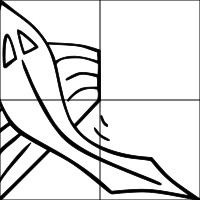

In [47]:
(render-debug fish)

In [48]:
(define fish2 (flip (rot45 fish)))
(define fish3 (rot (rot (rot fish2))))

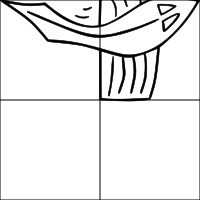

In [49]:
(render-debug fish2)

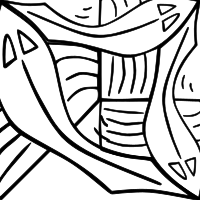

In [50]:
(define t (over fish (over fish2 fish3)))
(render t)

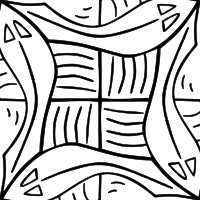

In [51]:
(define u (over fish2 (over (rot fish2) (over (rot (rot fish2)) fish3))))
(render u)

In [52]:

(define (blank) (lambda () ""))
(define _ (blank))

(define (side n)
    (cond ((= n 0) _)
          (else 
               (below
                    (beside (side (- n 1)) (side (- n 1)))
                    (beside (rot t) t)))))

(define (corner n) 
      (cond ((= n 0) _)
            (else 
                 (quartlet
                      (corner (- n 1))
                      (side (- n 1))
                      (rot (side (- n 1)))
                      u)))) 

(define (beside3 s1 s2 s3) 
      (combine-generic-args
               (pipeline
                    s1
                    (scale (/ 1 3.0) 1)
                    (translate (- (/ 200 3.0)) 0))
               (pipeline
                    s2
                    (scale (/ 1 3.0) 1))
               (pipeline
                    s3
                    (scale (/ 1 3.0) 1)
                    (translate (/ 200 3.0) 0))))


(define (below3 s1 s2 s3) 
      (combine-generic-args
               (pipeline
                    s1
                    (scale 1 (/ 1 3.0))
                    (translate 0 (- (/ 200 3.0))))
               (pipeline
                    s2
                    (scale 1 (/ 1 3.0)))
               (pipeline
                    s3
                    (scale 1 (/ 1 3.0))
                    (translate 0 (/ 200 3.0)))))

(define (nonet s1 s2 s3 s4 s5 s6 s7 s8 s9) 
    (below3 
         (beside3 s1 s2 s3)
         (beside3 s4 s5 s6)
         (beside3 s7 s8 s9)))

(define (square-limit n) 
      (if (= n 0) _
      (nonet
           (corner (- n 1))
           (side (- n 1))
           (rot (rot (rot (corner (- n 1)))))
           (rot (side (- n 1)))
           u
           (rot (rot (rot (side (- n 1)))))
           (rot (corner (- n 1)))
           (rot (rot (side (- n 1))))
           (rot (rot (corner (- n 1)))))))

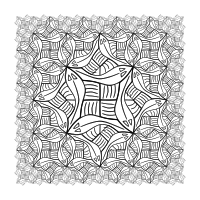

In [53]:
(render (square-limit 3))